In [ ]:
import torch

# CUDA 가용 여부 확인
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU.")
    print(f"Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. PyTorch is using CPU.")

print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

CUDA is available. PyTorch is using GPU.
Device: NVIDIA L4
0
NVIDIA L4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 경로 설정
drive_dir = "drive/My Drive/유지훈_연습(빅핀)/MLDL/"
model_dir = drive_dir + "model/"
path = drive_dir + "data/ai_and_real_images/"

In [ ]:
"""
# Datasets and DataLoaders
"""
import os
from glob import glob

import torch
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T

torch.manual_seed(2024)


class CustomDataset(Dataset):

    def __init__(self, root, transformations=None):

        self.transformations = transformations  # 이미지에 적용할 변환(전처리)
        self.im_paths = [
            im_path for im_path in sorted(glob(f"{root}/*/*/*"))
        ]  # 주어진 root 경로에서 모든 이미지 파일 리스트로 저장

        # cls_names: 각 클래스(폴더명)에 대한 인덱스 번호를 부여하는 딕셔너리
        # self.cls_counts: 각 클래스의 이미지 개수를 저장하는 딕셔너리
        # 루프를 통해 각 이미지 파일의 경로에서 클래스 이름을 추출하고, 해당 클래스가 처음 등장하는 경우에는 cls_names에 새로운 인덱스를 할당
        # 그렇지 않으면 기존 클래스의 이미지 개수만 증가시킴
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    # get_class 메서드: 이미지 경로에서 클래스를 추출하는 함수로, 경로의 마지막 폴더명을 클래스 이름으로 사용
    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    # __len__ 메서드: 데이터셋의 전체 길이를 반환
    def __len__(self):
        return len(self.im_paths)

    # __getitem__ 메서드: 주어진 인덱스의 이미지를 로드하고, 변환을 적용한 후, 이미지와 클래스 레이블(ground truth)을 반환
    # im_path: 해당 이미지의 경로
    # Image.open(im_path).convert("RGB"): 이미지를 열고 RGB 모드로 변환
    # self.transformations(im): 사전에 정의한 변환을 이미지에 적용
    # return im, gt: 이미지와 해당 클래스 인덱스를 반환
    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt


# get_dls 함수: 데이터셋을 학습, 검증, 테스트 세트로 분리하고 DataLoader를 생성하는 함수
# bs: 배치 사이즈
# split: 학습, 검증, 테스트 데이터셋 비율 (0.9, 0.05, 0.05)
# ns: 데이터 로딩에 사용할 워커(worker) 수
# random_split: 주어진 비율에 따라 데이터셋을 학습, 검증, 테스트로 분할
# DataLoader: 학습 및 테스트를 위한 DataLoader 객체를 생성하며, 학습 데이터는 shuffle=True로 설정되어 있음
def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):

    ds = CustomDataset(root=root, transformations=transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = (
        DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns),
        DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns),
        DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns),
    )

    return tr_dl, val_dl, ts_dl, ds.cls_names


# root: 데이터셋의 경로
# mean, std: 이미지를 정규화하기 위한 평균 및 표준편차 값
# tfs: 이미지에 적용할 변환들을 T.Compose로 묶음. 이미지 크기 조정, 텐서 변환, 그리고 정규화
# get_dls 함수 호출을 통해 학습, 검증, 테스트용 DataLoader를 생성
root = path
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose(
    [T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)]
)
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

# 학습, 검증, 테스트 DataLoader의 크기를 출력하고, 각 클래스의 이름과 인덱스를 출력
print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
print(classes)

309
18
550
{'ai_images': 0, 'real_images': 1}


In [ ]:
"""
# Data Visualization
"""
import numpy as np
import random
from matplotlib import pyplot as plt


# 텐서를 이미지로 변환하는 역할 훈련 중 사용된 역정규화를 적용하여 이미지를 복원함
# 이미지가 훈련 전에 정규화(Normalize)되었으므로, 이를 다시 복원하려면 반대로 정규화를 적용해야 함
# gray_tfs는 그레이스케일 이미지의 정규화를 반전시키기 위한 도구이고, rgb_tfs는 RGB 이미지에 대한 반전 도구임
# 작동 방식
# 입력 텐서 t는 정규화 반전(invTrans)을 거쳐 원래 픽셀 범위로 변환됨
# 이를 위해 255를 곱하고, CPU로 데이터를 전송한 후 NumPy 배열로 변환함
# 마지막으로, 배열의 형식을 uint8로 변환해 이미지를 준비함
def tensor_2_im(t, t_type="rgb"):
    gray_tfs = T.Compose(
        [T.Normalize(mean=[0.0], std=[1 / 0.5]), T.Normalize(mean=[-0.5], std=[1])]
    )
    rgb_tfs = T.Compose(
        [
            T.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
        ]
    )

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (
        (invTrans(t) * 255)
        .detach()
        .squeeze()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
        if t_type == "gray"
        else (invTrans(t) * 255)
        .detach()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
    )


# 지정된 데이터셋에서 무작위로 n_ims개의 이미지를 선택하고 시각화함
# 입력
# data: 시각화할 데이터셋
# n_ims: 시각화할 이미지의 개수
# rows: 시각화할 이미지의 행 개수
# cmap: 이미지가 RGB인지 그레이스케일인지 지정하는 값
# cls_names: 클래스 이름의 리스트로, 클래스의 인덱스를 기반으로 이름을 보여줌
# 시각화 과정
# 랜덤 인덱스 선택: indekslar는 random.randint를 사용하여 n_ims개의 무작위 인덱스를 선택함
# 이미지 플로팅: plt.subplot을 사용해 이미지를 여러 서브플롯에 plotting. tensor_2_im을 사용해 텐서를 이미지로 변환, 이를 plt.imshow로 시각화
# 레이블 추가: 만약 cls_names가 주어지면 이미지 상단에 해당 클래스의 이름을 제목으로 표시함. 그렇지 않으면 레이블을 그대로 표시
# assert문: cmap이 'rgb' 또는 'gray' 중 하나인지 확인함. 이 두 가지 형식이 아닌 경우 오류를 발생시킴
def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    assert cmap in [
        "rgb",
        "gray",
    ], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb":
        cmap = "viridis"

    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis("off")
        if cls_names is not None:
            plt.title(f"GT -> {cls_names[int(gt)]}")
        else:
            plt.title(f"GT -> {gt}")


# 학습, 검증, 테스트 데이터셋에 대해 각각 20개의 이미지를 시각화하는 함수 호출
# 각 함수 호출은 20개의 이미지를 4행으로 배치하고, RGB 형식의 이미지를 시각화
# classes.keys()는 각 클래스의 이름을 리스트로 전달하여, 각 이미지에 대한 클래스 이름을 표시함
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

<ipython-input-6-dd5ae7d0fb91>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation=60)


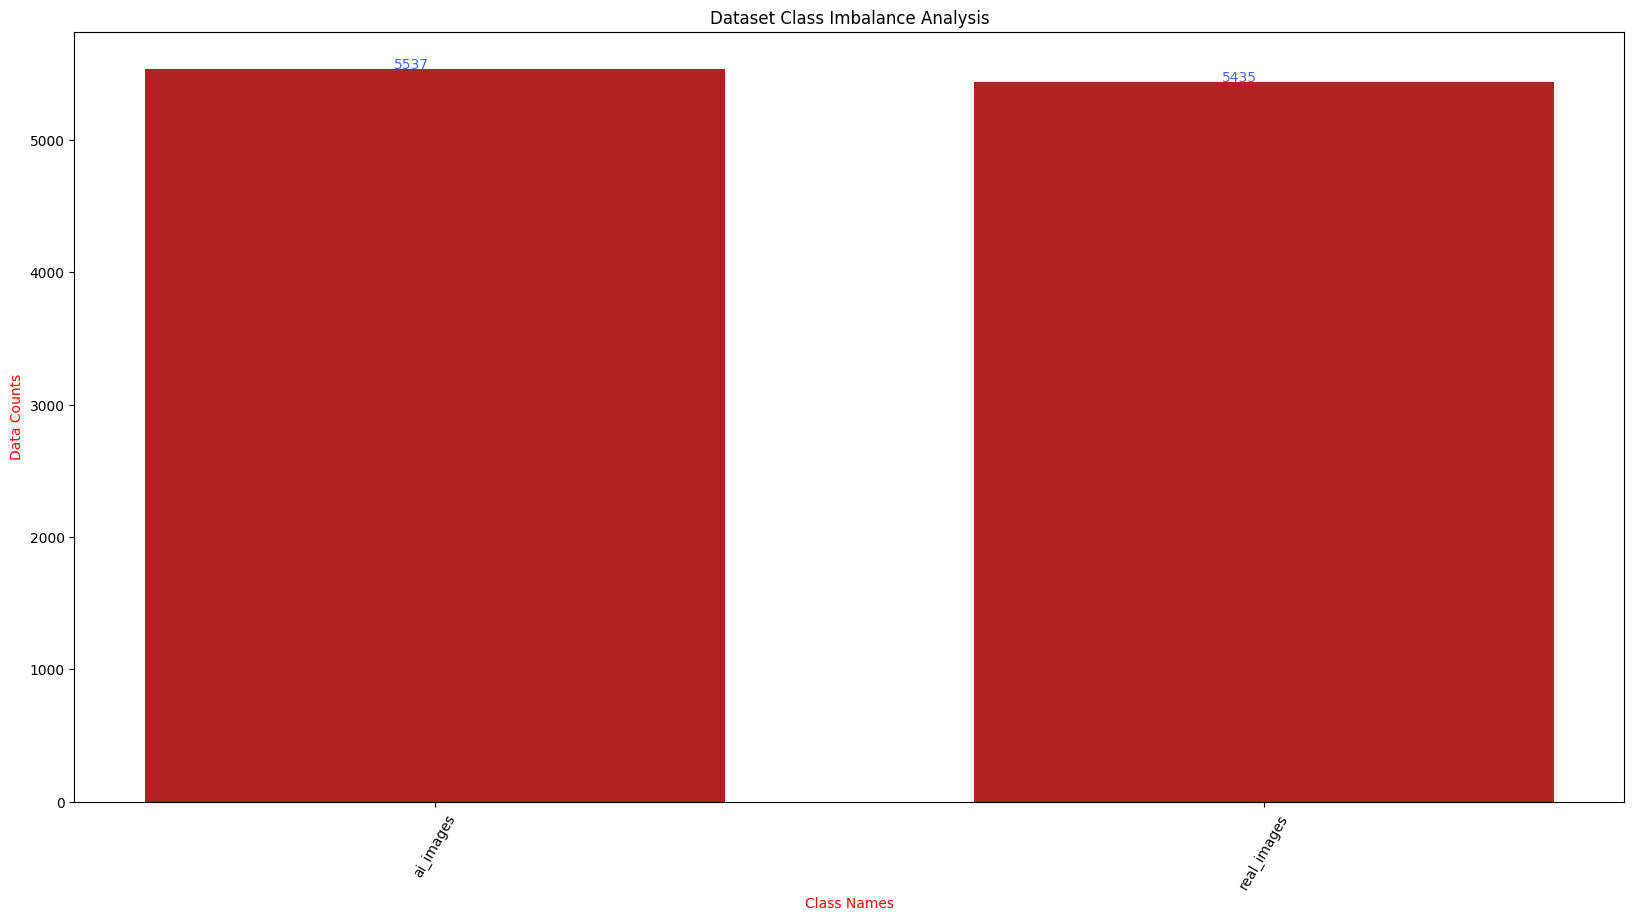

In [ ]:
"""
# Data Analysis
"""


# 데이터셋의 클래스 불균형을 분석하고 시각화하는 역할을 함
# 클래스별 데이터 수를 확인하기 위해 각 클래스의 이미지 개수를 그래프로 시각화함
# 각 클래스에 얼마나 많은 이미지가 있는지 한눈에 확인할 수 있음
def data_analysis(root, transformations):
    # CustomDataset 클래스의 인스턴스를 생성. 이 인스턴스는 root에 있는 모든 이미지 데이터를 불러와 각 클래스의 이미지 개수를 계산함
    ds = CustomDataset(root=root, transformations=transformations)
    # cls_counts: 각 클래스의 이미지 개수를 나타내는 딕셔너리(self.cls_counts)를 불러옴
    # cls_names: 클래스 이름의 리스트로 변환함
    # counts: 각 클래스에 해당하는 이미지 개수 리스트를 만듦
    # width: 막대의 너비를 설정
    # text_width, text_height: 각 막대 위에 표시될 텍스트의 위치를 조정하는 데 사용
    cls_counts, width, text_width = ds.cls_counts, 0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())

    # plt.subplots(figsize=(20, 10)): 20x10의 크기로 플롯을 생성
    # np.arange(len(counts)): 막대그래프의 x축 인덱스를 생성
    # ax.bar(indices, counts, width, color="firebrick"): 각 클래스별로 막대를 그리며, 막대는 counts에 있는 이미지 개수를 나타냄
    # 색상은 firebrick으로 지정되어 붉은 색의 막대가 그려짐
    # ax.set_xlabel, ax.set_ylabel: x축과 y축의 레이블을 설정하고 색상을 red로 지정함
    # ax.set_xticklabels(cls_names, rotation=60): 클래스 이름을 x축 레이블로 설정하며, 60도 회전하여 표시함
    # ax.set_title: 플롯의 제목을 설정
    fig, ax = plt.subplots(figsize=(20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color="firebrick")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60)
    ax.set(xticks=indices, xticklabels=cls_names)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    # for 루프는 각 클래스의 이미지 개수를 막대 위에 텍스트로 표시함
    # ax.text: 각 막대 위에 counts 값(이미지 개수)을 텍스트로 추가함.
    # 텍스트의 위치는 막대의 중심에서 약간 왼쪽(i - text_width), 막대 상단보다 약간 위(v + text_height)에 배치되며, 텍스트 색상은 royalblue로 설정됨
    for i, v in enumerate(counts):
        ax.text(i - text_width, v + text_height, str(v), color="royalblue")


data_analysis(root=root, transformations=tfs)

In [ ]:
!pip install timm torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 53.8 MB/s eta 0:00:00


In [ ]:
"""
# AI Model Train and Validation
"""
# ResNet 변형 모델(ReXNet-150)을 이용하여 AI 모델을 학습 및 검증하는 과정을 구현한 것
# 모델 학습과 관련된 주요 함수들과 로직이 포함되어 있으며, 훈련 및 검증 중 손실, 정확도, F1 점수를 추적함
import timm, torchmetrics
from tqdm import tqdm


# timm.create_model은 ResNet 변형인 ReXNet-150 모델을 불러옴
# pretrained=True: 사전 훈련된 가중치를 사용
# num_classes=len(classes): 분류할 클래스의 수를 지정함
m = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes))


# m.to("cuda").eval(): 모델을 GPU로 이동하고, 초기 상태를 평가 모드로 설정함
# torch.nn.CrossEntropyLoss(): 손실 함수로 교차 엔트로피 손실을 사용
# torch.optim.Adam: Adam 옵티마이저를 사용하며, 학습률은 0.0003
def train_setup(m):
    return (
        m.to("cuda").eval(),
        10,
        "cuda",
        torch.nn.CrossEntropyLoss(),
        torch.optim.Adam(params=m.parameters(), lr=3e-4),
    )


# 데이터 배치(입력 이미지와 정답 라벨)를 GPU로 이동시킴
def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)


# 모델 예측(preds), 손실 계산(loss), 정확도(epoch_acc), F1 점수(epoch_f1)를 업데이트하는 함수
# torch.argmax(preds, dim=1) == gts: 예측값과 실제값을 비교하여 정확도를 계산함
# f1_score: 다중 클래스 F1 점수를 계산함
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return (
        loss,
        epoch_loss + (loss.item()),
        epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item(),
        epoch_f1 + f1_score(preds, gts),
    )


m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)
save_prefix, save_dir = "AI", model_dir
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)


# 훈련 루프에서는 각 에폭마다 배치 단위로 모델을 학습시킴
# 손실을 역전파(loss.backward())한 후 옵티마이저가 파라미터를 업데이트(optimizer.step())함
# 에폭마다 누적된 손실(epoch_loss), 정확도(epoch_acc), F1 점수(epoch_f1)를 기록함
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):
        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(
            m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_f1_to_track = epoch_f1 / len(tr_dl)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)
    tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    # 검증 단계에서는 torch.no_grad()로 그라디언트 계산을 비활성화하여 검증 손실, 정확도, F1 점수를 평가합니다.
    # 검증 성능이 개선되었을 경우, 모델을 저장함
    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(
                m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1
            )

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_f1_to_track = val_epoch_f1 / len(val_dl)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)
        val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        # 검증 손실이 개선되면 모델의 가중치를 저장함
        # 개선되지 않는 경우 not_improved 카운터를 증가시키고, 설정한 patience 만큼 개선되지 않으면 훈련을 중지함
        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok=True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(
                    f"Stop training since loss value did not decrease for {patience} epochs."
                )
                break

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


85it [06:39,  1.31s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [14:30,  2.82s/it]

1-epoch train process is completed!
1-epoch train loss          -> 0.339
1-epoch train accuracy      -> 0.873
1-epoch train f1-score      -> 0.873


1-epoch validation process is completed!
1-epoch validation loss     -> 0.142
1-epoch validation accuracy -> 0.953
1-epoch validation f1-score -> 0.943


105it [00:17,  7.07it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
240it [00:39,  6.64it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:51,  6.03it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.174
2-epoch train accuracy      -> 0.933
2-epoch train f1-score      -> 0.933


2-epoch validation process is completed!
2-epoch validation loss     -> 0.111
2-epoch validation accuracy -> 0.954
2-epoch validation f1-score -> 0.957


137it [00:23,  6.17it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:50,  6.18it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.130
3-epoch train accuracy      -> 0.951
3-epoch train f1-score      -> 0.951


3-epoch validation process is completed!
3-epoch validation loss     -> 0.130
3-epoch validation accuracy -> 0.940
3-epoch validation f1-score -> 0.943
Loss value did not decrease for 1 epochs


5it [00:01,  4.61it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
111it [00:18,  7.07it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:50,  6.13it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.108
4-epoch train accuracy      -> 0.960
4-epoch train f1-score      -> 0.960


4-epoch validation process is completed!
4-epoch validation loss     -> 0.126
4-epoch validation accuracy -> 0.956
4-epoch validation f1-score -> 0.958
Loss value did not decrease for 2 epochs


47it [00:08,  5.66it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
201it [00:33,  7.27it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:51,  5.99it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.121
5-epoch train accuracy      -> 0.957
5-epoch train f1-score      -> 0.957


5-epoch validation process is completed!
5-epoch validation loss     -> 0.106
5-epoch validation accuracy -> 0.960
5-epoch validation f1-score -> 0.962


197it [00:32,  6.26it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
264it [00:43,  6.88it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:50,  6.13it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.065
6-epoch train accuracy      -> 0.977
6-epoch train f1-score      -> 0.977


6-epoch validation process is completed!
6-epoch validation loss     -> 0.207
6-epoch validation accuracy -> 0.920
6-epoch validation f1-score -> 0.911
Loss value did not decrease for 3 epochs


78it [00:12,  7.29it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
252it [00:42,  6.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:51,  6.05it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.060
7-epoch train accuracy      -> 0.978
7-epoch train f1-score      -> 0.978


7-epoch validation process is completed!
7-epoch validation loss     -> 0.180
7-epoch validation accuracy -> 0.964
7-epoch validation f1-score -> 0.965
Loss value did not decrease for 4 epochs


164it [00:28,  4.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
244it [00:40,  6.24it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
309it [00:51,  6.05it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.062
8-epoch train accuracy      -> 0.977
8-epoch train f1-score      -> 0.977


8-epoch validation process is completed!
8-epoch validation loss     -> 0.127
8-epoch validation accuracy -> 0.962
8-epoch validation f1-score -> 0.964
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


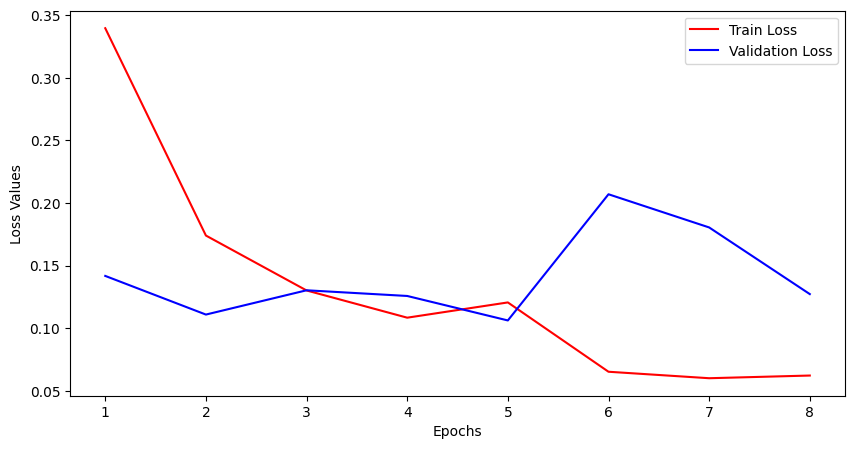

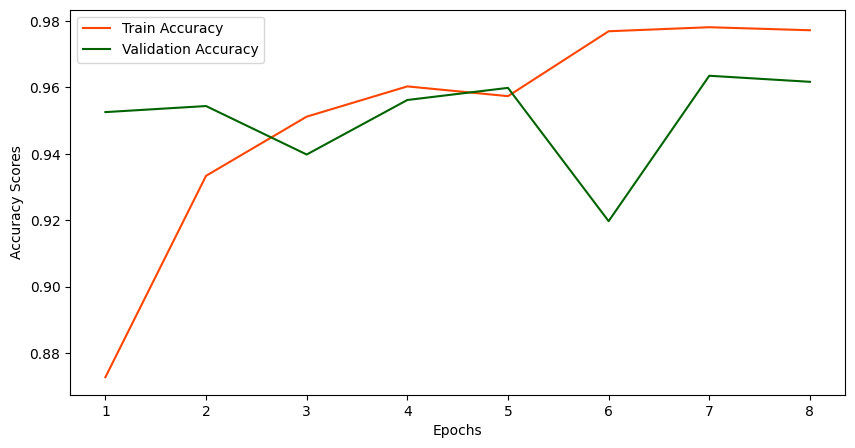

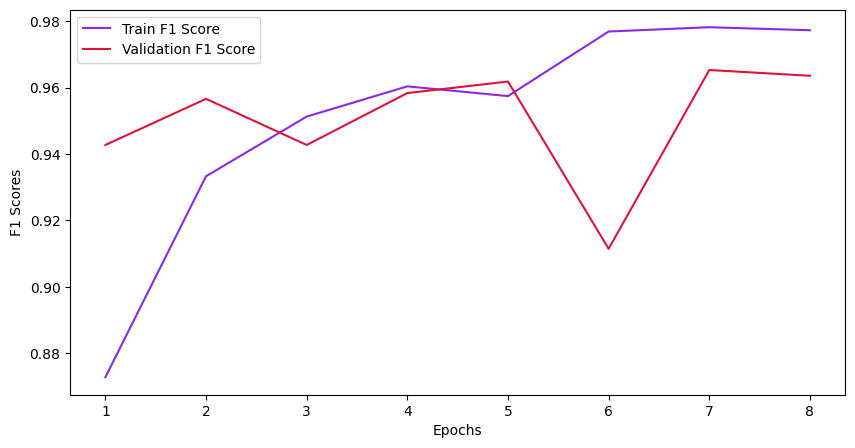

In [ ]:
"""
# Learning Curves
"""


# 모델 학습 과정에서 기록된 손실, 정확도, F1 점수 등의 학습 곡선을 시각화하는 클래스
# 각 에폭(epoch)에서 얻어진 학습 및 검증 결과들을 그래프로 그려줌
class PlotLearningCurves:

    # __init__ 함수에서 학습 및 검증 손실(tr_losses, val_losses), 정확도(tr_accs, val_accs), F1 점수(tr_f1s, val_f1s)를 입력 받음
    # 이를 변수로 저장
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        (
            self.tr_losses,
            self.val_losses,
            self.tr_accs,
            self.val_accs,
            self.tr_f1s,
            self.val_f1s,
        ) = (tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s)

    # plot 함수는 두 개의 배열을 각각 그래프에 그림. 학습 곡선과 검증 곡선을 각각 지정된 라벨과 색상으로 그리기 위해 사용됨
    # array_1, array_2는 각각의 학습 및 검증 데이터를 나타냄
    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        plt.plot(array_1, label=label_1, c=color_1)
        plt.plot(array_2, label=label_2, c=color_2)

    # 새로운 플롯을 생성할 때 호출되며, 그림의 크기는 10x5로 설정됨
    def create_figure(self):
        plt.figure(figsize=(10, 5))

    # 플롯의 장식을 담당합니다. x축과 y축에 각각 라벨을 설정하며, x축은 각 에폭 번호에 해당하는 값으로 표시됨
    # plt.legend()는 범례를 추가하며, plt.show()는 그래프를 화면에 출력함
    def decorate(self, ylabel, xlabel="Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(
            ticks=np.arange(len(self.tr_accs)),
            labels=[i for i in range(1, len(self.tr_accs) + 1)],
        )
        plt.legend()
        plt.show()

    # visualize 함수는 총 3개의 그래프를 생성함
    # 손실 곡선(Loss curves): 훈련과 검증 손실을 각각 빨간색(Train Loss)과 파란색(Validation Loss)으로 시각화
    # 정확도 곡선(Accuracy curves): 훈련과 검증 정확도를 각각 주황색(Train Accuracy)과 녹색(Validation Accuracy)으로 시각화
    # F1 점수 곡선(F1 Score curves): 훈련과 검증 F1 점수를 각각 보라색(Train F1 Score)과 진홍색(Validation F1 Score)으로 시각화
    # 각 플롯마다 create_figure로 새로운 그래프를 생성하고, plot 함수로 데이터를 그린 후, decorate 함수로 축 라벨, 범례 등을 설정하여 완성
    def visualize(self):
        # Figure 1
        self.create_figure()
        self.plot(
            array_1=self.tr_losses,
            array_2=self.val_losses,
            label_1="Train Loss",
            label_2="Validation Loss",
            color_1="red",
            color_2="blue",
        )
        self.decorate(ylabel="Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(
            array_1=self.tr_accs,
            array_2=self.val_accs,
            label_1="Train Accuracy",
            label_2="Validation Accuracy",
            color_1="orangered",
            color_2="darkgreen",
        )
        self.decorate(ylabel="Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(
            array_1=[tr_f1.cpu() for tr_f1 in self.tr_f1s],
            array_2=[vl_f1.cpu() for vl_f1 in self.val_f1s],
            label_1="Train F1 Score",
            label_2="Validation F1 Score",
            color_1="blueviolet",
            color_2="crimson",
        )
        self.decorate(ylabel="F1 Scores")


# 클래스 인스턴스를 생성하면서 학습 및 검증의 손실, 정확도, F1 점수 데이터를 넘겨주고, visualize() 함수를 호출하여 학습 곡선을 화면에 시각화
PlotLearningCurves(
    tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
).visualize()

<ipython-input-10-0c7ec3792f4a>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
550it [00:46, 11

Accuracy of the model on the test data -> 0.945


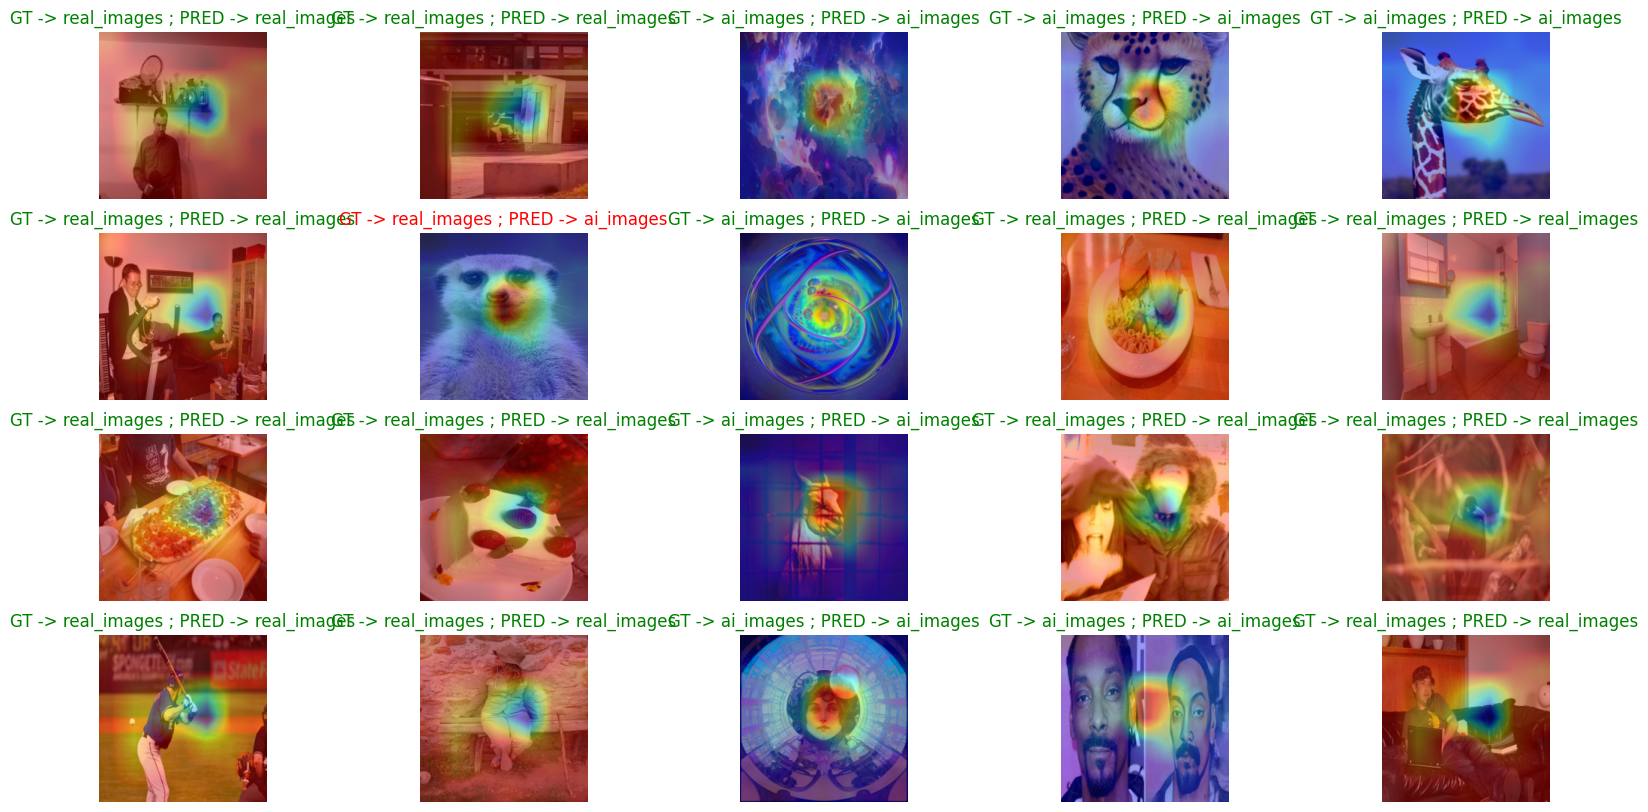

In [ ]:
"""
# Inference and AI Model Performance Analysis
"""
# 모델 추론(Inference) 및 성능 분석(Performance Analysis)을 수행하며, Class Activation Map(CAM)을 활용해 시각화도 하고 있음
# 이는 모델의 예측이 각 이미지의 어떤 부분에 주목하고 있는지 시각적으로 표현해줌
import cv2


# 지정된 레이어의 활성화값(activation)을 저장하는 역할을 함. forward hook을 이용해 레이어의 출력을 후처리 없이 저장할 수 있음
class SaveFeatures:
    """Extract pretrained activations"""

    # __init__: 생성자에서 model의 특정 레이어에 hook을 등록함. 이 hook은 forward pass가 일어날 때마다 해당 레이어의 출력을 hook_fn으로 전달함
    # hook_fn: 이 함수는 forward pass가 발생할 때 레이어의 출력을 받아서 features 변수에 저장함. 이때 데이터를 .cpu()로 변환한 후 numpy 배열로 변환함
    # remove: hook을 제거하는 메서드
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()


# Class Activation Map(CAM)을 생성함. 이 함수는 모델이 예측한 클래스에 따라 어떤 영역이 중요하게 작용했는지 시각화하는 열지도를 생성함
# conv_fs는 마지막 합성곱 층의 출력으로, 해당 값과 linear_weights (fully connected 레이어의 가중치)를 곱해 각 위치에 대한 클래스 중요도를 계산함
# 계산된 CAM은 이미지 크기로 재구성됨
# 마지막으로, 값들을 0과 1 사이로 정규화하여 반환함
def getCAM(conv_fs, linear_weights, class_idx):
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(
        conv_fs[
            0,
            :,
            :,
        ].reshape((chs, h * w))
    )
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)


# 모델을 사용하여 테스트 데이터셋에서 추론을 수행하고, 모델의 정확도를 계산함. 또한, CAM을 시각화함
# SaveFeatures 객체를 생성하여 마지막 합성곱 레이어의 출력을 저장하도록 hook을 등록함
# 테스트 데이터셋에서 각 이미지를 추론하고, 예측된 클래스와 실제 클래스의 일치 여부를 확인하여 정확도를 계산함
# 각 이미지에 대해 모델의 예측 클래스의 CAM을 생성하고 저장함
def inference(
    model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names=None
):
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim=1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(
        f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}"
    )

    # 모델이 예측한 이미지의 CAM을 시각화함
    # 무작위로 선택된 이미지에 대해 CAM을 생성한 후, 해당 이미지를 시각화함
    # 예측된 클래스와 실제 클래스의 이름을 출력하며, 예측이 맞았으면 초록색, 틀렸으면 빨간색으로 표시됨
    # CAM은 cv2.resize를 통해 원본 이미지 크기에 맞게 조정된 후, 원본 이미지 위에 투명하게 오버레이됨
    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap="gray")
        plt.axis("off")
        plt.imshow(
            cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR),
            alpha=0.4,
            cmap="jet",
        )
        plt.axis("off")

        if cls_names is not None:
            plt.title(
                f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}",
                color=(
                    "green"
                    if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]}
                    else "red"
                ),
            )
        else:
            plt.title(f"GT -> {gt} ; PRED -> {preds}")


# 모델 로드: 학습된 모델 가중치를 불러옴
# 레이어 설정: CAM 생성을 위해 마지막 합성곱 층(final_conv)과 최종 fully connected 층의 파라미터(fc_params)를 설정함
# 추론 실행: inference 함수를 호출하여 테스트 데이터셋에 대한 추론을 수행하고 결과를 시각화함
m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(
    model=m.to(device),
    device=device,
    test_dl=ts_dl,
    num_ims=20,
    row=4,
    cls_names=list(classes.keys()),
    final_conv=final_conv,
    fc_params=fc_params,
)